## **Machine Learning - Projeto , Yan Romano, Pedro DeLucca , Leonardo**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from PIL import Image
from pathlib import Path

def load_images():
    # Ajusta o caminho para a pasta de imagens no Google Drive
    image_paths = list(Path('/content/drive/MyDrive/Colab Notebooks/Machine Learning Project/images').rglob('*.jpg'))
    images = []

    for image_path in image_paths:
        # Extraindo o ID da imagem assumindo o padrão 'nome_ID.extensão'
        try:
            id = int(image_path.stem.split('_')[1])  # Usa .stem para obter o nome sem a extensão
        except (IndexError, ValueError):
            print(f"Formato de nome inesperado em {image_path}. Pulando esta imagem.")
            continue

        # Carrega e redimensiona a imagem
        with Image.open(image_path) as img:
            img = img.resize((100, 100))
            images.append((id, img))

    return images

# Chama a função para carregar as imagens
images = load_images()


In [2]:
import pandas as pd

# Carregar dados
dados = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Machine Learning Project/Tables/processed_tables/dados_limpos.xlsx')

In [3]:
images_df = pd.DataFrame(images, columns=['id','image'])
df = dados.join(images_df.set_index('id'), on='id')
X = df['image']
y = df['industryName']

In [4]:
import tensorflow as tf

tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
images_dict = dict(images)

df['imagem'] = df['id'].map(images_dict)

print(df.head())

   Unnamed: 0         id industryName  followersCount  experience  \
0           0   43695134      Banking            1476      2556.0   
1           1  154315745      Banking             666      4901.0   
2           2     643247      Banking             802      9039.0   
3           3  107217342      Banking             579      4690.0   
4           5  745012591      Banking             897      6666.0   

                                               image  \
0  <PIL.Image.Image image mode=RGB size=100x100 a...   
1  <PIL.Image.Image image mode=RGB size=100x100 a...   
2  <PIL.Image.Image image mode=RGB size=100x100 a...   
3  <PIL.Image.Image image mode=RGB size=100x100 a...   
4  <PIL.Image.Image image mode=RGB size=100x100 a...   

                                              imagem  
0  <PIL.Image.Image image mode=RGB size=100x100 a...  
1  <PIL.Image.Image image mode=RGB size=100x100 a...  
2  <PIL.Image.Image image mode=RGB size=100x100 a...  
3  <PIL.Image.Image image mo

In [6]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [7]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tf_keras

In [8]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [12]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 100
def make_model():
  inputs = tf.keras.layers.Input(shape=[100, 100, 3])
  Z = tf.keras.layers.Flatten()(inputs)
  Z = tf.keras.layers.Dense(150, activation="relu")(Z)
  Z = tf.keras.layers.Dense(100, activation="relu")(Z)
  codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
  codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
  codings = Sampling()([codings_mean, codings_log_var])
  variational_encoder = tf.keras.Model(
      inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
  decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
  x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
  x = tf.keras.layers.Dense(150, activation="relu")(x)
  x = tf.keras.layers.Dense(100 * 100*3)(x)
  outputs = tf.keras.layers.Reshape([100, 100, 3])(x)
  variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])
  _, _, codings = variational_encoder(inputs)
  reconstructions = variational_decoder(codings)
  variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])
  latent_loss = -0.5 * tf.reduce_sum(
      1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
      axis=-1)
  variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)
  return variational_ae


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten, Dense, Input, Reshape

# Verifica se as entradas são imagens válidas e remove as linhas com entradas não-imagem
df = df[df['imagem'].apply(lambda img: isinstance(img, Image.Image))]

# Verificando e convertendo as imagens para o formato correto (numpy array)
def convert_images_to_array(df):
    images_array = []

    for img in df['imagem']:
        # Garantir que a imagem é válida e não é None
        if isinstance(img, Image.Image):
            # Converte a imagem para RGB se ela não for RGB
            img_resized = img.resize((100, 100))  # Redimensiona
            img_rgb = img_resized.convert('RGB')  # Força a conversão para RGB
            img_array = np.array(img_rgb)  # Converte para numpy array
            # Garantir que o array tenha 3 canais de cor (RGB)
            if img_array.shape == (100, 100, 3):
                images_array.append(img_array)
            else:
                print(f"Imagem com formato inesperado: {img_array.shape}")
        else:
            print(f"Imagem inválida ou não encontrada: {img}")

    # Converte a lista de arrays para um único array numpy
    return np.array(images_array)

# Chama a função para garantir que todas as imagens estão no formato correto
X = convert_images_to_array(df)

# Verificando o shape final de X
print(X.shape)

y = df['industryName']

# Separar os dados em treino e validação
X_train, X_valid, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)




(694, 100, 100, 3)


In [14]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        print(tf.shape(log_var))
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

inputs = tf.keras.layers.Input(shape=[100, 100, 3])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)

codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])

x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(100 * 100*3)(x)

outputs = tf.keras.layers.Reshape([100, 100, 3])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Tensor("Shape:0", shape=(2,), dtype=int32)


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reconstructions(model, images=X_valid, n_images=5):
    # Fazendo as previsões das reconstruções
    reconstructions = model.predict(images[:n_images])
    minval = reconstructions.min()
    maxval = reconstructions.max()
    reconstructions = (reconstructions - minval)/(maxval - minval)

    # Configurando a visualização
    fig = plt.figure(figsize=(n_images * 1.5, 3))

    for image_index in range(n_images):
        # Mostrando as imagens originais
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index])
        plt.axis("off")

        # Mostrando as imagens reconstruídas
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index])
        plt.axis("off")

# Após treinar o modelo, você pode chamar a função de plotagem:
plot_reconstructions()
plt.show()


In [11]:
import tensorflow as tf

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.random.normal(tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

class LatentLossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        codings_mean, codings_log_var = inputs
        # Evitar NaNs usando clip_by_value para manter exp e log_var em faixa segura
        log_var = tf.clip_by_value(codings_log_var, -10.0, 10.0)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + log_var - tf.exp(log_var) - tf.square(codings_mean),
            axis=-1
        )
        # Adicionando a perda ao modelo
        self.add_loss(tf.reduce_mean(latent_loss) / 784.)
        return codings_mean

# Normalizar a entrada
X_train = X_train / 255.0
X_valid = X_valid / 255.0

# Parâmetros do modelo
codings_size = 40

# Encoder
inputs = tf.keras.layers.Input(shape=[100, 100, 3])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)

codings_mean = tf.keras.layers.Dense(codings_size)(Z)
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)
codings = Sampling()([codings_mean, codings_log_var])

# Camada de perda latente
codings_mean = LatentLossLayer()([codings_mean, codings_log_var])

# Construindo o modelo Encoder
variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(100 * 100 * 3)(x)
outputs = tf.keras.layers.Reshape([100, 100, 3])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

# Conectando Encoder e Decoder
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

# Compilando o modelo
variational_ae.compile(loss="mse", optimizer="nadam")

# Treinamento
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_valid, X_valid))


Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 897ms/step - loss: 12994.3467 - val_loss: 231.5956
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 98.7544 - val_loss: 55.1627
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 35.8289 - val_loss: 33.0496
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 22.6230 - val_loss: 14.8803
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.2248 - val_loss: 6.9091
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.5893 - val_loss: 2.6236
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.9752 - val_loss: 1.3436
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1275 - val_loss: 0.8818
Epoch 9/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.7438 - val_loss: 0.5992
Epoch 10/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5147 - val_loss: 0.4369
Epoch 11/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3863 - val_loss: 0.3526
Epoch 12/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3260 - val

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Shape das imagens originais: (5, 100, 100, 3)
Shape das reconstruções após squeeze: (5, 100, 100, 3)


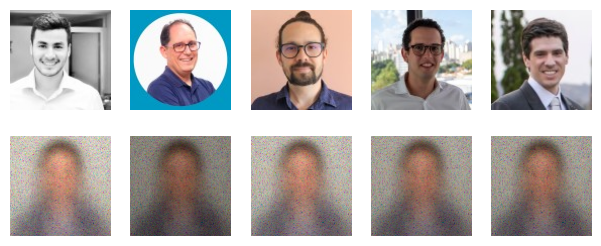

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reconstructions(model, images, n_images=5):
    # Seleciona as primeiras n_images imagens e transforma em float32
    images = np.array(images[:n_images]).astype(np.float32)

    # Gera as reconstruções e converte para array
    reconstructions = np.array(model.predict(images)).astype(np.float32)

    # Remover a dimensão extra das reconstruções
    reconstructions = np.squeeze(reconstructions, axis=0)

    # Verifica as formas das imagens
    print(f"Shape das imagens originais: {images.shape}")
    print(f"Shape das reconstruções após squeeze: {reconstructions.shape}")

    # Normaliza ambas as imagens e reconstruções para o intervalo [0, 1]
    images = (images - images.min()) / (images.max() - images.min())
    reconstructions = (reconstructions - reconstructions.min()) / (reconstructions.max() - reconstructions.min())

    # Configura a visualização
    fig = plt.figure(figsize=(n_images * 1.5, 3))

    for image_index in range(n_images):
        # Exibe a imagem original
        plt.subplot(2, n_images, 1 + image_index)
        if images[image_index].ndim == 3:  # Se for RGB
            plt.imshow(images[image_index])
        else:  # Se for escala de cinza
            plt.imshow(images[image_index], cmap="gray")
        plt.axis("off")

        # Exibe a imagem reconstruída
        plt.subplot(2, n_images, 1 + n_images + image_index)
        if reconstructions[image_index].ndim == 3:  # Se for RGB
            plt.imshow(reconstructions[image_index])
        else:  # Se for escala de cinza
            plt.imshow(reconstructions[image_index], cmap="gray")
        plt.axis("off")

# Chama a função para exibir as reconstruções
plot_reconstructions(variational_ae, images=X_valid, n_images=5)
plt.show()
